# Graph Auto-Encoder (GAE)

This file is for design purposes - will first try it with one dataset and one way of representing, and then move on to other datasets and ways of representing it. Based on https://github.com/pyg-team/pytorch_geometric/blob/master/examples/autoencoder.py.

**Note: I'm trying to work with sparse matrices as much as possible. If this is not possible, I will need to change back to dense matrices. But for memory efficiency, sparse matrices are much better.**

## Import packages

In [1]:
# import packages
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# import python files needed to create adjacency matrices
import reading_data

## Read in data

In [4]:
# for the AIFB+, filtered, not-relational, sparse
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="separate", sparse=True)
number_nodes = adjacency_matrix.size()[0]

In [5]:
adjacency_matrix.coalesce().indices()

tensor([[    0,     0,     0,  ...,  2834,  2834,  2834],
        [   57,   111,   157,  ...,  8718, 10658, 10993]])

## Create feature matrix (one-hot)

In [6]:
feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))

In [7]:
feature_matrix

tensor(indices=tensor([[    0,     1,     2,  ..., 11537, 11538, 11539],
                       [    0,     1,     2,  ..., 11537, 11538, 11539]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(11540, 11540), nnz=11540, layout=torch.sparse_coo)

## Create a data object

In [8]:
data_aifb = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes)

In [9]:
data_aifb

Data(x=[11540, 11540], edge_index=[2, 29043], num_nodes=11540)

In [10]:
data_aifb.is_directed()

True

In [11]:
data_aifb.num_node_features

11540

**Split it into three:**

In [12]:
# set up a link split function --> have to split the labels into positive and negative
transformation = RandomLinkSplit(split_labels=True, add_negative_train_samples=False)

# split the data into a train, validation and test set
aifb_train, aifb_val, aifb_test = transformation(data_aifb)

In [13]:
aifb_train

Data(x=[11540, 11540], edge_index=[2, 20331], num_nodes=11540, pos_edge_label=[20331], pos_edge_label_index=[2, 20331])

In [14]:
aifb_val

Data(x=[11540, 11540], edge_index=[2, 20331], num_nodes=11540, pos_edge_label=[2904], pos_edge_label_index=[2, 2904], neg_edge_label=[2904], neg_edge_label_index=[2, 2904])

In [15]:
aifb_test

Data(x=[11540, 11540], edge_index=[2, 23235], num_nodes=11540, pos_edge_label=[5808], pos_edge_label_index=[2, 5808], neg_edge_label=[5808], neg_edge_label_index=[2, 5808])

Later on, this can be expanded, by, for example, adding labels and training, validation, and testing masks. For only the GAE, though, this is not needed.

## Create the GCN-encoder and the GAE

In [16]:
class GCN_encoder(torch.nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()
        self.layer1 = GCNConv(input_nodes, hidden_nodes)
        self.layer2 = GCNConv(hidden_nodes, output_nodes)
    
    def forward(self, X, A):
        h1 =  self.layer1(X, A)
        h1_activated = F.relu(h1)
        h2 = self.layer2(h1_activated, A)
        return h2

In [17]:
input_n = data_aifb.num_features
hidden_n = 200
output_n = 30
encoder = GCN_encoder(input_n, hidden_n, output_n)
model = GAE(encoder) # decoder is not needed, as it is implied

## Run a training loop

In [18]:
# needed for the training loop:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
nr_epochs = 100

In [19]:
recon_valid_run = list()
auc_valid_run = list()
ap_valid_run = list()

for epoch in range(nr_epochs):
    # set to training mode, put the grads to zero:
    model.train()
    optimizer.zero_grad()
    
    # encode everything in latent space using the encoder
    latent_space = model.encode(aifb_train.x, aifb_train.edge_index)
    
    # calculate the reconstruction loss and perform the backwards operation
    reconstruction_loss = model.recon_loss(latent_space, aifb_train.pos_edge_label_index)
    reconstruction_loss.backward()
    
    # update the parameters
    optimizer.step()
    
    # clip weights?
    # --- also, other optimization steps here ----
    
    # now, evaluate the model as it currently is, and save this information:
    model.eval()
    latent_space_valid = model.encode(aifb_val.x, aifb_val.edge_index)
    reconstruction_loss_valid = model.recon_loss(latent_space_valid, aifb_val.pos_edge_label_index, aifb_val.neg_edge_label_index) 
    AUC_valid, average_precision_valid = model.test(latent_space_valid, aifb_val.pos_edge_label_index, aifb_val.neg_edge_label_index)
    
    recon_valid_run.append(reconstruction_loss_valid.item())
    auc_valid_run.append(AUC_valid.item())
    ap_valid_run.append(average_precision_valid.item())

print(recon_valid_run)
print(auc_valid_run)
print(ap_valid_run)

[1.362058162689209, 1.3049805164337158, 1.2319586277008057, 1.1931350231170654, 1.2105778455734253, 1.2018848657608032, 1.1695587635040283, 1.145520567893982, 1.1412158012390137, 1.1530671119689941, 1.174067735671997, 1.2094134092330933, 1.2664648294448853, 1.3396999835968018, 1.4155144691467285, 1.4764573574066162, 1.512782096862793, 1.5221221446990967, 1.50689697265625, 1.4771820306777954, 1.4385019540786743, 1.3998355865478516, 1.3632429838180542, 1.3299636840820312, 1.3024499416351318, 1.2804765701293945, 1.2649717330932617, 1.2546448707580566, 1.2493585348129272, 1.2497787475585938, 1.253612995147705, 1.2611536979675293, 1.2718749046325684, 1.2846753597259521, 1.2986855506896973, 1.315173625946045, 1.3320353031158447, 1.3483083248138428, 1.3620400428771973, 1.3730206489562988, 1.382702112197876, 1.388515830039978, 1.3924429416656494, 1.392345666885376, 1.387614130973816, 1.3797048330307007, 1.3701226711273193, 1.360473871231079, 1.349714756011963, 1.340929388999939, 1.334614276885

## Analysis of results

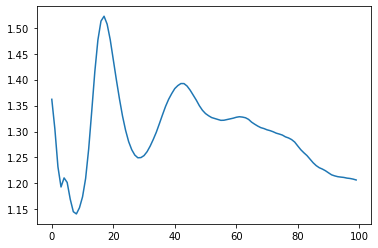

In [20]:
plt.plot(recon_valid_run)

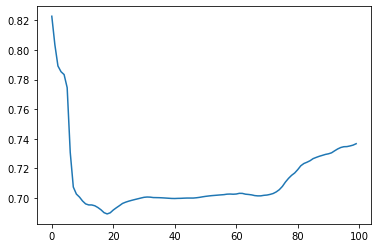

In [21]:
plt.plot(auc_valid_run)

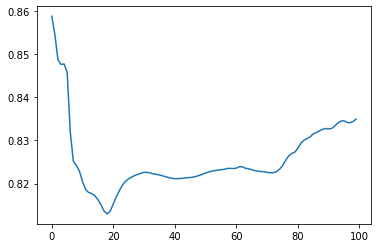

In [22]:
plt.plot(ap_valid_run)

## The streamlined version:

In [1]:
import GAE_model

In [2]:


# run_gae_model(dataset_filename, literal_representation, hidden_nodes, output_nodes, optimizer, learning_rate,
#                  weight_decay, nr_epochs, seed, test=True, record_results=False)

results = GAE_model.run_gae_model(dataset_filename="data/aifb/aifb+.nt", literal_representation="collapsed", hidden_nodes=100, output_nodes=30, optimizer="adam", learning_rate=0.05,
                  weight_decay=0.001, nr_epochs=100, seed=10, test=True, record_results=False)

Epoch:  1 , Rec_Loss_Train:  1.3858751058578491 , Rec_Loss_Test:  1.2811497449874878 , AUC_test:  0.8156949155198976 , AP_test:  0.8540143110971737
Epoch:  2 , Rec_Loss_Train:  1.283610224723816 , Rec_Loss_Test:  1.260152816772461 , AUC_test:  0.8435624982251329 , AP_test:  0.8754993514637017
Epoch:  3 , Rec_Loss_Train:  1.2594714164733887 , Rec_Loss_Test:  2.622345209121704 , AUC_test:  0.8584229155177522 , AP_test:  0.8879613574241995
Epoch:  4 , Rec_Loss_Train:  2.6396427154541016 , Rec_Loss_Test:  1.2024222612380981 , AUC_test:  0.8249577630031351 , AP_test:  0.8716743373390559
Epoch:  5 , Rec_Loss_Train:  1.1917691230773926 , Rec_Loss_Test:  1.3685634136199951 , AUC_test:  0.7463443546588859 , AP_test:  0.8242343983349609
Epoch:  6 , Rec_Loss_Train:  1.367002010345459 , Rec_Loss_Test:  1.3803941011428833 , AUC_test:  0.8037371305553418 , AP_test:  0.8480046157862606
Epoch:  7 , Rec_Loss_Train:  1.3797521591186523 , Rec_Loss_Test:  1.376394271850586 , AUC_test:  0.7878552688144936 

Epoch:  58 , Rec_Loss_Train:  0.9904948472976685 , Rec_Loss_Test:  1.165688157081604 , AUC_test:  0.778615440595117 , AP_test:  0.8624669662384193
Epoch:  59 , Rec_Loss_Train:  0.9884734153747559 , Rec_Loss_Test:  1.159913420677185 , AUC_test:  0.7786549681724781 , AP_test:  0.8620772101026106
Epoch:  60 , Rec_Loss_Train:  0.9869892597198486 , Rec_Loss_Test:  1.1556265354156494 , AUC_test:  0.7815531903373683 , AP_test:  0.8637692696786512
Epoch:  61 , Rec_Loss_Train:  0.987259030342102 , Rec_Loss_Test:  1.1544651985168457 , AUC_test:  0.7793277862420134 , AP_test:  0.8622476875376301
Epoch:  62 , Rec_Loss_Train:  0.9888407588005066 , Rec_Loss_Test:  1.1568219661712646 , AUC_test:  0.7818634512762938 , AP_test:  0.8639500444435146
Epoch:  63 , Rec_Loss_Train:  0.9867714643478394 , Rec_Loss_Test:  1.1593663692474365 , AUC_test:  0.7790072150567501 , AP_test:  0.8622729248237
Epoch:  64 , Rec_Loss_Train:  0.9848302602767944 , Rec_Loss_Test:  1.1599626541137695 , AUC_test:  0.781765265548

In [3]:
results = GAE_model.run_gae_model(dataset_filename="data/aifb/aifb+.nt", literal_representation="collapsed", hidden_nodes=100, output_nodes=30, optimizer="adam", learning_rate=0.05,
                  weight_decay=0.001, nr_epochs=100, seed=10, test=True, record_results=False)

Epoch:  1 , Rec_Loss_Train:  1.385866641998291 , Rec_Loss_Test:  1.2817060947418213 , AUC_test:  0.8106112936114108 , AP_test:  0.849679229385041
Epoch:  2 , Rec_Loss_Train:  1.2822275161743164 , Rec_Loss_Test:  1.2585686445236206 , AUC_test:  0.8426950817055734 , AP_test:  0.8752349063799241
Epoch:  3 , Rec_Loss_Train:  1.2592501640319824 , Rec_Loss_Test:  2.662642478942871 , AUC_test:  0.8577570851729749 , AP_test:  0.8869871367615373
Epoch:  4 , Rec_Loss_Train:  2.6726438999176025 , Rec_Loss_Test:  1.1999356746673584 , AUC_test:  0.8296099338806285 , AP_test:  0.875280886397026
Epoch:  5 , Rec_Loss_Train:  1.1924879550933838 , Rec_Loss_Test:  1.3700531721115112 , AUC_test:  0.7545885438442779 , AP_test:  0.8295124938115662
Epoch:  6 , Rec_Loss_Train:  1.3693183660507202 , Rec_Loss_Test:  1.384216070175171 , AUC_test:  0.6707394821556603 , AP_test:  0.7576433554378039
Epoch:  7 , Rec_Loss_Train:  1.3838814496994019 , Rec_Loss_Test:  1.3800127506256104 , AUC_test:  0.7589144669413423 

Epoch:  59 , Rec_Loss_Train:  0.9879894256591797 , Rec_Loss_Test:  1.1507881879806519 , AUC_test:  0.7873393989168103 , AP_test:  0.8678392445516254
Epoch:  60 , Rec_Loss_Train:  0.9910231828689575 , Rec_Loss_Test:  1.1491107940673828 , AUC_test:  0.7842809507560883 , AP_test:  0.8660145867505585
Epoch:  61 , Rec_Loss_Train:  0.9933491945266724 , Rec_Loss_Test:  1.146437168121338 , AUC_test:  0.7851781656754676 , AP_test:  0.8666166216736096
Epoch:  62 , Rec_Loss_Train:  0.9944627285003662 , Rec_Loss_Test:  1.1462910175323486 , AUC_test:  0.7859307540613206 , AP_test:  0.8671817667043722
Epoch:  63 , Rec_Loss_Train:  0.988210916519165 , Rec_Loss_Test:  1.1447556018829346 , AUC_test:  0.7842527018730588 , AP_test:  0.8658536854865144
Epoch:  64 , Rec_Loss_Train:  0.9944376945495605 , Rec_Loss_Test:  1.1442466974258423 , AUC_test:  0.786101528690689 , AP_test:  0.8671279426747095
Epoch:  65 , Rec_Loss_Train:  0.9890709519386292 , Rec_Loss_Test:  1.1450223922729492 , AUC_test:  0.78430721

In [3]:
results

{'latent_space': tensor([[ 1.4077e-01, -8.9746e-02,  7.8131e-02,  ...,  1.2431e-01,
           4.2306e-01,  7.5174e-02],
         [-1.2205e-01,  7.5762e-02, -6.4092e-02,  ..., -1.0752e-01,
          -3.7642e-01, -6.3865e-02],
         [-1.2457e-01,  7.4865e-02, -9.8322e-02,  ..., -1.1308e-01,
          -3.6154e-01, -5.9059e-02],
         ...,
         [ 2.3851e-02, -1.6282e-02,  9.2461e-03,  ...,  2.0102e-02,
           7.3137e-02,  1.4271e-02],
         [ 7.5727e-04, -1.3846e-03,  1.0581e-03,  ...,  7.3375e-04,
          -1.0081e-04,  1.3535e-03],
         [-1.7233e-02,  9.8435e-03, -1.0639e-02,  ..., -1.4642e-02,
          -5.3659e-02, -7.1372e-03]], grad_fn=<AddBackward0>),
 'loss_list_train': [1.385850429534912,
  1.2838349342346191,
  1.3024593591690063,
  2.085739850997925,
  1.2295373678207397,
  1.3694900274276733,
  1.3807148933410645,
  1.3736857175827026,
  1.353196144104004,
  1.3079019784927368,
  1.2699660062789917,
  1.2890766859054565,
  1.2414929866790771,
  1.18925833

In [ ]:
# these are the basics to run the experiment --> add this in an extra experiment file later on!! one notebook with all experiments!


# set the seed
    torch_geometric.seed.seed_everything(seed)
    
# create the adjacency matrix
    adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt(
        dataset_filename, literal_representation=literal_representation, sparse=True)

    # record the number of nodes
    number_nodes = adjacency_matrix.size()[0]

    # create the one-hot feature matrix:
    feature_matrix = torch.sparse_coo_tensor(
        indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),
        size=(number_nodes, number_nodes))

    # create a data object --> with the already created adjacency matrix
    data = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes)

    # split the edges into a training, validation, and test sets
    # set up a link split function --> have to split the labels into train, test and validation
    if test:
        # do not take in validation data! only have a train-test split!
        transformation = RandomLinkSplit(split_labels=True, add_negative_train_samples=False, num_val=0)
    else:
        # there will be validation data!
        transformation = RandomLinkSplit(split_labels=True, add_negative_train_samples=False)

    # split the data into a train, validation and test set
    train_data, val_data, test_data = transformation(data)